In [ ]:
import pandas
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Reading data using Pandas
data = pandas.read_csv("./circles_binary_classification.csv")

# Check to see if the data is loaded correctly
data.head(5)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


In [ ]:
# Summary of the data
data.describe()

,X1,X2,label
count,1000.000000,1000.000000,1000.00000
mean,-0.000448,-0.000804,0.50000
std,0.639837,0.641156,0.50025
min,-1.059502,-1.067768,0.00000
25%,-0.619251,-0.612176,0.00000
50%,0.008762,-0.003949,0.50000
75%,0.621933,0.624822,1.00000
max,1.033712,1.036004,1.00000


In [ ]:
# Data cleaning and preprocessing

# remove missing values rows
data = data.dropna()

# force the data to be numeric
data = data.apply(pandas.to_numeric, errors='coerce')

# feature engineering
X = data[["X1", "X2"]]
Y = data["label"]

In [ ]:
# converting to Tensors
import torch
from torch import nn
X_tensor = torch.tensor(X.values, dtype=torch.float32)
Y_tensor = torch.tensor(Y.values, dtype=torch.float32)

# Check cleaned data
torch.isnan(X_tensor).any().item()

False

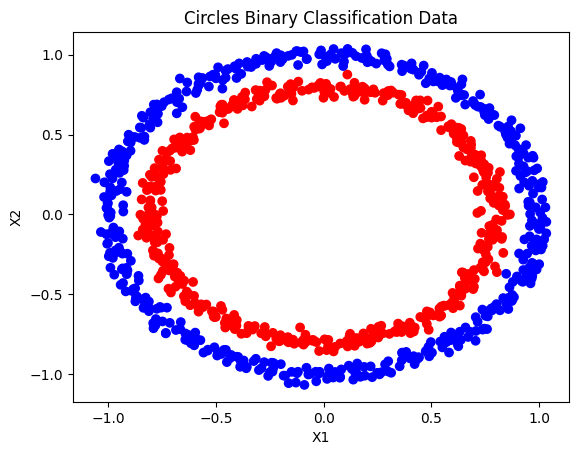

In [ ]:
# Data visualization
plt.scatter(X_tensor[:, 0], X_tensor[:, 1], c=Y_tensor, cmap="bwr")
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("Circles Binary Classification Data")
plt.show()

In [ ]:
# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_tensor, Y_tensor, test_size=0.2, random_state=42)

# Move tensors to device
X_train = X_train.to(device)
X_test = X_test.to(device)
Y_train = Y_train.to(device)
Y_test = Y_test.to(device)

print(f"X_train device: {X_train.device}")
print(f"X_test device: {X_test.device}")

X_train device: cuda:0
X_test device: cuda:0


In [ ]:
class ModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 5),
            nn.Linear(5, 1)
        )

    def forward(self, x):
        return self.net(x)

# 4. instance of the model and send it to target device
model_0 = ModelV0().to(device)
model_0

ModelV0(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): Linear(in_features=5, out_features=1, bias=True)
  )
)

In [ ]:
class ModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 15),
            nn.Linear(15, 15),
            nn.Linear(15, 1)
        )

    def forward(self, x):
        return self.net(x)

# 4. instance of the model and send it to target device
model_1 = ModelV1().to(device)
model_1

ModelV1(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=15, bias=True)
    (1): Linear(in_features=15, out_features=15, bias=True)
    (2): Linear(in_features=15, out_features=1, bias=True)
  )
)

In [ ]:
class ModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )

    def forward(self, x):
        return self.net(x)
    
# 4. instance of the model and send it to target device
model_2 = ModelV2().to(device)
model_2

ModelV2(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [ ]:
def binary_accuracy_from_logits(logits, y_true):
    probs = torch.sigmoid(logits)
    preds = torch.round(probs)            # 0/1
    correct = (preds == y_true).float().mean()
    return correct.item()

In [ ]:
def train_model(model, X_train, y_train, X_test, y_test, epochs=100, lr=0.1, print_every=10):
    """
    Trains and evaluates one binary-classification model using:
      - BCEWithLogitsLoss (raw logits)
      - SGD optimizer

    Returns:
      results dict with train/test losses and accuracies per epoch
    """
    # --- Reinitialize model parameters (important between experiments) ---
    def reset_weights(m):
        if hasattr(m, "reset_parameters"):
            m.reset_parameters()
    model.apply(reset_weights)

    model = model.to(device)
    X_train, y_train = X_train.to(device), y_train.to(device)
    X_test, y_test = X_test.to(device), y_test.to(device)

    # Ensure target shape/dtype for BCEWithLogitsLoss
    y_train = y_train.view(-1, 1).float()
    y_test = y_test.view(-1, 1).float()

    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(params=model.parameters(), lr=lr)  # new optimizer per experiment

    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    for epoch in range(epochs):
        # -------------------- Train --------------------
        model.train()
        train_logits = model(X_train)                    # raw logits
        train_loss = loss_fn(train_logits, y_train)
        train_acc = binary_accuracy_from_logits(train_logits, y_train)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        # -------------------- Eval ---------------------
        model.eval()
        with torch.inference_mode():
            test_logits = model(X_test)                  # raw logits
            test_loss = loss_fn(test_logits, y_test)
            test_acc = binary_accuracy_from_logits(test_logits, y_test)

        # store history
        results["train_loss"].append(train_loss.item())
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss.item())
        results["test_acc"].append(test_acc)

        # print progress every N epochs
        if epoch % print_every == 0 or epoch == epochs - 1:
            print(
                f"Epoch {epoch:4d}/{epochs-1} | "
                f"Train Loss: {train_loss.item():.4f}, Train Acc: {train_acc:.4f} | "
                f"Test Loss: {test_loss.item():.4f}, Test Acc: {test_acc:.4f}"
            )

    return results

In [ ]:
# Example:
results_v0 = train_model(ModelV0(), X_train, Y_train, X_test, Y_test, epochs=100)

Epoch    0/99 | Train Loss: 0.7072, Train Acc: 0.4600 | Test Loss: 0.7080, Test Acc: 0.4550
Epoch   10/99 | Train Loss: 0.7011, Train Acc: 0.4837 | Test Loss: 0.7021, Test Acc: 0.4450
Epoch   20/99 | Train Loss: 0.6980, Train Acc: 0.4950 | Test Loss: 0.6990, Test Acc: 0.4450
Epoch   30/99 | Train Loss: 0.6961, Train Acc: 0.4988 | Test Loss: 0.6973, Test Acc: 0.4300
Epoch   40/99 | Train Loss: 0.6950, Train Acc: 0.4975 | Test Loss: 0.6963, Test Acc: 0.4650
Epoch   50/99 | Train Loss: 0.6943, Train Acc: 0.4937 | Test Loss: 0.6957, Test Acc: 0.4800
Epoch   60/99 | Train Loss: 0.6938, Train Acc: 0.4937 | Test Loss: 0.6954, Test Acc: 0.4900
Epoch   70/99 | Train Loss: 0.6936, Train Acc: 0.4925 | Test Loss: 0.6951, Test Acc: 0.5050
Epoch   80/99 | Train Loss: 0.6934, Train Acc: 0.4875 | Test Loss: 0.6950, Test Acc: 0.4950
Epoch   90/99 | Train Loss: 0.6932, Train Acc: 0.4950 | Test Loss: 0.6949, Test Acc: 0.4900
Epoch   99/99 | Train Loss: 0.6932, Train Acc: 0.4937 | Test Loss: 0.6949, Test 

In [ ]:
results_v1 = train_model(ModelV1(), X_train, Y_train, X_test, Y_test, epochs=1000)

Epoch    0/999 | Train Loss: 0.6945, Train Acc: 0.5000 | Test Loss: 0.6945, Test Acc: 0.5000
Epoch   10/999 | Train Loss: 0.6935, Train Acc: 0.5000 | Test Loss: 0.6936, Test Acc: 0.5000
Epoch   20/999 | Train Loss: 0.6932, Train Acc: 0.5000 | Test Loss: 0.6934, Test Acc: 0.5000
Epoch   30/999 | Train Loss: 0.6931, Train Acc: 0.4487 | Test Loss: 0.6935, Test Acc: 0.4200
Epoch   40/999 | Train Loss: 0.6931, Train Acc: 0.4862 | Test Loss: 0.6936, Test Acc: 0.4850
Epoch   50/999 | Train Loss: 0.6931, Train Acc: 0.4963 | Test Loss: 0.6937, Test Acc: 0.4800
Epoch   60/999 | Train Loss: 0.6930, Train Acc: 0.5000 | Test Loss: 0.6939, Test Acc: 0.4650
Epoch   70/999 | Train Loss: 0.6930, Train Acc: 0.5025 | Test Loss: 0.6940, Test Acc: 0.4600
Epoch   80/999 | Train Loss: 0.6930, Train Acc: 0.5075 | Test Loss: 0.6941, Test Acc: 0.4700
Epoch   90/999 | Train Loss: 0.6930, Train Acc: 0.5087 | Test Loss: 0.6942, Test Acc: 0.4650
Epoch  100/999 | Train Loss: 0.6930, Train Acc: 0.5075 | Test Loss: 0.

In [ ]:
results_v2 = train_model(ModelV2(), X_train, Y_train, X_test, Y_test, epochs=500)

Epoch    0/499 | Train Loss: 0.7040, Train Acc: 0.5000 | Test Loss: 0.7042, Test Acc: 0.5000
Epoch   10/499 | Train Loss: 0.6991, Train Acc: 0.5000 | Test Loss: 0.6994, Test Acc: 0.5000
Epoch   20/499 | Train Loss: 0.6965, Train Acc: 0.5000 | Test Loss: 0.6969, Test Acc: 0.5000
Epoch   30/499 | Train Loss: 0.6950, Train Acc: 0.5000 | Test Loss: 0.6955, Test Acc: 0.5000
Epoch   40/499 | Train Loss: 0.6942, Train Acc: 0.5000 | Test Loss: 0.6948, Test Acc: 0.5000
Epoch   50/499 | Train Loss: 0.6936, Train Acc: 0.5000 | Test Loss: 0.6943, Test Acc: 0.5000
Epoch   60/499 | Train Loss: 0.6933, Train Acc: 0.5000 | Test Loss: 0.6941, Test Acc: 0.5000
Epoch   70/499 | Train Loss: 0.6930, Train Acc: 0.5000 | Test Loss: 0.6939, Test Acc: 0.5000
Epoch   80/499 | Train Loss: 0.6927, Train Acc: 0.5000 | Test Loss: 0.6937, Test Acc: 0.5000
Epoch   90/499 | Train Loss: 0.6925, Train Acc: 0.5000 | Test Loss: 0.6936, Test Acc: 0.5000
Epoch  100/499 | Train Loss: 0.6923, Train Acc: 0.5000 | Test Loss: 0.